In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import seaborn

# Principal Components Analysis of a set of stocks 

In [21]:
prices_long = pd.read_csv('data/stock_prices.csv', index_col = [0, 1],  parse_dates = True, squeeze = True)
dji_all = pd.read_csv('data/DJI.csv', index_col = 0, parse_dates = True)

Some convenience functions to be used later.

In [22]:
calc_returns = lambda x: np.log(x / x.shift(1))[1:]
scale        = lambda x: (x - x.mean()) / x.std()
    
def OLSreg(y, Xmat):
    return sm.OLS(y, sm.add_constant(Xmat, prepend = True)).fit()

The prices dataset is in a longitudinal format (i.e. rows = no. days $\times$ no. of stocks and cols = 1 (price)). We'll unstack it, to make a 'wide' dataset with rows = no. days and columns = no. stocks, with each cell the corresponding price.

We'll also remove a ticker and a date with missing data.

In [23]:
prices = prices_long.unstack()
dates = list(prices.index)
dates.remove(dt.datetime(2002, 2, 1))
prices = prices.drop('DDR', axis = 1)
prices = prices.drop([dt.datetime(2002, 2, 1)])

In [24]:
prices.shape

(2366, 24)

Create a dataset with the daily returns to each stock.

In [25]:
returns = prices.apply(calc_returns)

The Dow Jones index data is sorted latest date first, so we sort it. Then, we'll keep only the closing price, and calculate returns.

In [26]:
dji_all = dji_all.sort_index()
dji = dji_all['Close'].reindex(index = dates)
dji_ret = calc_returns(dji)

We want to try two types of PCA index. 

First, as in the book, one that performs PCA on the correlation matrix of stock prices. 

But stock prices are non-stationary, so the estimated correlation matrix is not meaningful. So we'll repeat the exercise with returns correlations.

The function `make_pca_index` wraps scikit-learn's `PCA` function. We'll pass it either the prices or returns, and it will compute a correlation matrix and return the first principal component (scaled to have mean 0, variance 1).

In [27]:
def make_pca_index(data, scale_data = True):
    '''
    Compute the correlation matrix of a set of stock data, and return
    the first principal component.

    By default, the data are scaled to have mean zero and variance one
    before performing the PCA.
    '''
    if scale_data:
        data_std = data.apply(scale)
    else:
        data_std = data
    corrs = np.asarray(data_std.cov())
    pca   = PCA(n_components = 1).fit(corrs)
    mkt_index = -scale(pca.transform(data_std))
    return mkt_index

First the price index

In [28]:
price_index = make_pca_index(prices)

Now we graph the relationship between the PCA index and the Dow Jones index. There is a positive relationship, but given the statistical issues with performing PCA on non-stationary data, it should be considered spurious.

*Note:* This code breaks under pandas 0.9.0 due to a bug. If you're running 0.8.x or 0.9.1 it should be fine, but if it generates an error, upgrade your pandas version, or remove the last line of the block (`plt.legend(...)`).

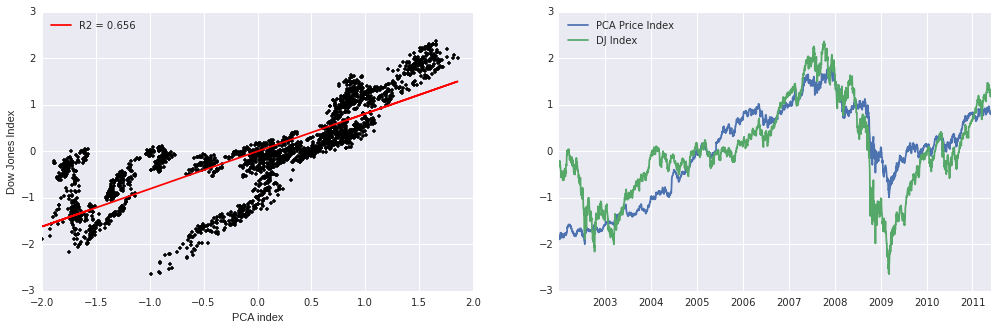

In [36]:
plt.figure(figsize = (17, 5))
plt.subplot(121)
plt.plot(price_index, scale(dji), 'k.')
plt.xlabel('PCA index')
plt.ylabel('Dow Jones Index')
ols_fit = OLSreg(scale(dji), price_index)
plt.plot(price_index, ols_fit.fittedvalues, 'r-', 
         label = 'R2 = %4.3f' % round(ols_fit.rsquared, 3))
plt.legend(loc = 'upper left')
plt.subplot(122)
plt.plot(dates, price_index, label = 'PCA Price Index')
plt.plot(dates, scale(dji), label = 'DJ Index')
plt.legend(loc = 'upper left')

Now, let's create a PCA index using the returns. 

In [30]:
returns_index = make_pca_index(returns)

Comparing the returns PCA index to the returns to the Dow Jone index, we find a more reliable and meaningful relationship.

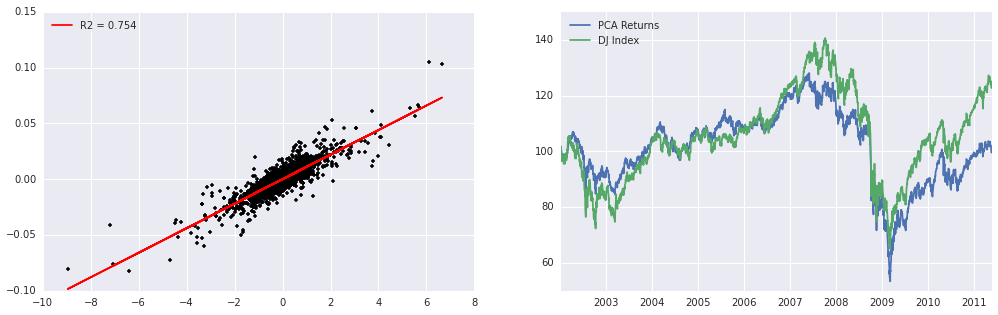

In [37]:
ols_fit = OLSreg(dji_ret, returns_index)
plt.figure(figsize = (17, 5))
plt.subplot(121)
plt.plot(returns_index, dji_ret, 'k.')
plt.plot(returns_index, ols_fit.fittedvalues, 'r-', 
         label = ('R2 = %4.3f' % round(ols_fit.rsquared, 3)))
plt.legend(loc = 'upper left', frameon = False)
plt.subplot(122)
plt.plot(dates[1:], 100*np.exp((returns_index * dji_ret.std()).cumsum()), 
         label = 'PCA Returns')
plt.plot(dates[1:], 100*np.exp(dji_ret.cumsum()), label = 'DJ Index')
plt.legend(loc = 'upper left')

Lastly, let's examine how much of the variance in stock returns is explained by each principal component.

We see that the first component explaines about 35% of the variance and by the fourth, we've explained more than half. 

In [32]:
pca_fit = PCA(n_components = 24).fit(returns.corr())

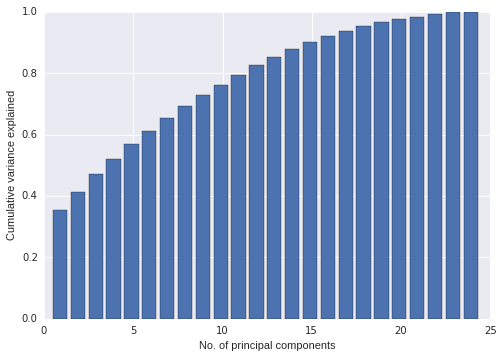

In [38]:
plt.bar(arange(24) + .5, pca_fit.explained_variance_ratio_.cumsum())
plt.ylim((0, 1))
plt.xlabel('No. of principal components')
plt.ylabel('Cumulative variance explained')
plt.grid(axis = 'y', ls = '-', lw = 1, color = 'white')

If we plot the loadings of the first component across our stocks, we see that this component loads approximately evenly (with a few exceptions) across the stocks. So the interpretation of this variable as a "market" factor or index is reasonable.

<Container object of 24 artists>

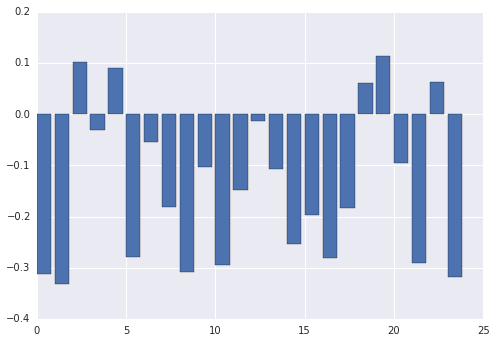

In [39]:
plt.bar(arange(24), pca_fit.components_[0])